In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import bs4 as bs
import pickle
import os
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import RcParams
import mpl_finance as finance
import matplotlib.ticker as ticker
from matplotlib.dates import date2num, DayLocator, DateFormatter
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader as web
import fix_yahoo_finance as yf
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import talib as ta
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model

ModuleNotFoundError: No module named 'talib'

# Outline

* Exploratory data analysis (EDA)
* Set up features (high-low, high-Close(previous), low-Close(previous))
* Set up MAC/D signaling
* calculate true range(TR) and average true range (ATR)
* set up volatility index from previous historical values
* Look into GARCH modeling for volatility
* Compounded annual percent returns
* log return for GARCH modeling


# Data preparation

In [ ]:
style.use('ggplot')
plt.rcParams['figure.figsize'] = (15,7) # Setting default params for figures
# set start date to point 4 years from today's current day and end dat as the current date. Dynamically updates itself
start = dt.datetime.now() - dt.timedelta(days = 4 * 365)
end = dt.datetime.now()

yf.pdr_override()
#%matplotlib inline

In [ ]:
# scraping all the company tickers from the S&P 500
def save_sp500_companies():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[1].text
        tickers.append(ticker)
    # saves the data into a local format so I don't have to reload it everytime
    with open('sp500tickers.pickle', 'wb') as f:
        pickle.dump(tickers, f)
        
    print(tickers)
    return tickers

In [ ]:
def get_data_yahoo(reload_sp500=False):
    if reload_sp500:
        tickers = save_sp500_companies()        
    else:
        with open('sp500tickers.pickle', 'rb') as f:
            tickers = pickle.load(f)
            
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')
    # get the first 50 companies from the S&P 500
    for ticker in tickers[:50]:
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            df = yf.download(ticker, start, end)
            df.to_csv('stock_dfs/{}.csv'.format(ticker))
        else:
            print("{} already exists.".format(ticker))
            
get_data_yahoo(reload_sp500=True)

In [2]:
def compile_dfs():
    with open('sp500tickers.pickle', 'rb') as f:
        tickers = pickle.load(f)
    comp_df = pd.DataFrame()
    
    for count, ticker in enumerate(tickers[:50]):
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df['Log_returns'] = np.log(df['Adj Close']) / np.log(df['Adj Close'].shift())
        df.rename(columns={'Log_returns': ticker}, inplace=True)
        df.index = pd.DatetimeIndex(df['Date'])
        df = df.drop(['Open', 'High' ,'Low', 'Close', 'Volume', 'Date', 'Adj Close'], 1)
        
        if comp_df.empty:
            comp_df = df
        else:
             comp_df = comp_df.join(df, how='outer')
                
        if count % 10 == 0 :
            print(count)
            
    print(comp_df.head())
    comp_df.to_csv('sp500_returns_joined.csv')
        
compile_dfs()

0
10
20
30
40
                 MMM       ABT  ABBV      ABMD  ACN      ATVI      ADBE  \
Date                                                                      
2000-01-03       NaN       NaN   NaN       NaN  NaN       NaN       NaN   
2000-01-04  0.987738  0.984759   NaN  0.991645  NaN  0.859320  0.968502   
2000-01-05  1.008743  0.999018   NaN  1.003636  NaN  1.020742  1.007267   
2000-01-06  1.023480  1.018381   NaN  1.000600  NaN  0.897591  1.002996   
2000-01-07  1.005830  1.005573   NaN  0.998198  NaN  1.159109  1.017430   

                 AMD  AAP       AES  ...       APH       APC       ADI  \
Date                                 ...                                 
2000-01-03       NaN  NaN       NaN  ...       NaN       NaN       NaN   
2000-01-04  0.978799  NaN  0.988042  ...  0.973368  1.000735  0.984916   
2000-01-05  1.009437  NaN  1.003205  ...  0.982496  1.005828  1.004276   
2000-01-06  1.023832  NaN  1.002374  ...  0.977759  1.006415  0.991858   
2000-01-07  1.00

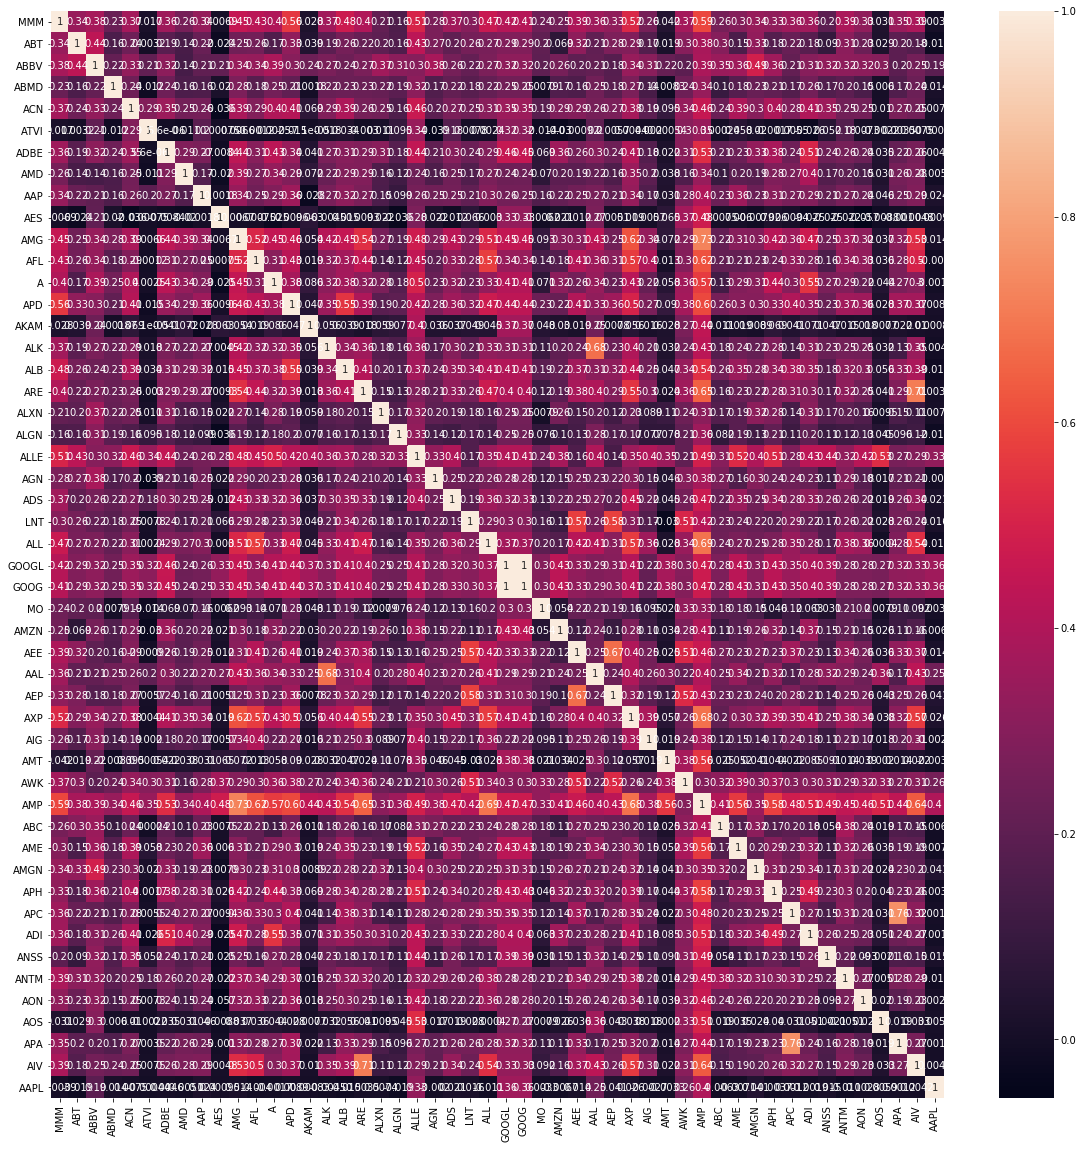

In [3]:
def visualize_company():
    fig = plt.figure(figsize=(20,20))
    df = pd.read_csv('sp500_returns_joined.csv')
    df_corr = df.corr()
    sns.heatmap(df_corr, annot=True)
    plt.show()
visualize_company()

## Visualizing stock information

There are usually 5 main features that form the basis for all stock market information and allow us to create a great many features to describe the data. The are the open, close, high, low, and volume. The first 4 variables are the price values for a stock at any given day and voulme is the number of shares being traded at that point. One important note is that there is a value called adjusted close, which refers to the close price in relation to the volume. During certain periods of time, a company may double the amount of stocks being shared, which causes the price of the close to fall by half. The stocks are still worth essentially the same, it's just a change in how the data is presented in the stock market. Because of this and many other changes that may occur in the stock market, the adjusted close is the value that takes into account these changes, thus it will be our value of interest. 

In [4]:
aapl_df = yf.download('AAPL', start, end)

NameError: name 'yf' is not defined

In [ ]:
#Past trading years closing price
aapl_df['Open'][:].plot(kind='line')
aapl_df['Adj Close'][:].plot(kind='line')
aapl_df['High'][:].plot(kind='line')
aapl_df['Low'][:].plot(kind='line')
plt.title('Adj Close Price')
plt.legend()
plt.show()

# Interpreting a candlebar graph

Regular line graphs are good and all for most numerical visualization, but finance data requires quite a bit of overlayed data which can be hard to read with traditional graphing methods. In order to remedy this, we will use something simple called Japanese Candlebar Graphs in order to visualize a great breadth of information. 

The candlebar graph conbeys a particular stock's high, low, open, and close prices for a given time period. The flat ends of the bar part of the graph represent the open and close price. The wicks coming out of the bars are indicators for the high and low price for that particular day. The addition of color changes how one reads the graphs.

The colors of the graph indicate direction of stock price for a given day. If a bar is green, then that means the stock was in an uptrend for the day and it closed higher than it opened for. With that in mind, the top wick indicates the days price high and the bottom wick indicates the days price low. The upper bart of the bar shows the close price and the lower part shows the days open price. 

When the bars are red, the major difference is that the indicators for the bars are switched. In red bars, the top part of the bar represents the open price and the bottom part represents the close price. The lines still hold their original meaning no matter the color. 

Now the color can be changed to any type we want but usually, downstrends are red and uptrends are either green or black. 

Armed with this knowledge, and with practice over time, one may graze over these graphs and gather a large amount of information and eventually form heuristics for price trends. 

In [9]:
aapl_df['Date'] = aapl_df.index.map(lambda x: date2num(x))
aapl_df.head()

,Open,High,Low,Close,Adj Close,Volume,Date
Date,,,,,,,
2015-03-25,126.540001,126.820000,123.379997,123.379997,115.027771,51655200,735682.0
2015-03-26,122.760002,124.879997,122.599998,124.239998,115.829559,47572900,735683.0
2015-03-27,124.570000,124.699997,122.910004,123.250000,114.906578,39546200,735684.0
2015-03-30,124.050003,126.400002,124.000000,126.370003,117.815361,47099700,735687.0
2015-03-31,126.089996,126.489998,124.360001,124.430000,116.006676,42090600,735688.0


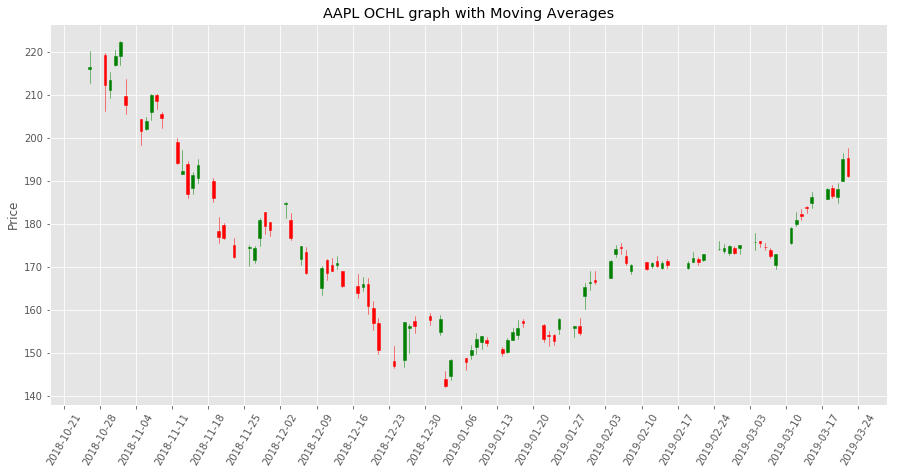

In [10]:
start=-100
fig, ax = plt.subplots()

finance.candlestick_ochl(ax,
                         quotes=aapl_df[['Date', 'Open', 'Close', 'High', 'Low']][start:].values,
                         width=.5,
                         colorup='green'
                         )
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.xticks(rotation=60)
plt.ylabel("Price")
plt.title("AAPL OCHL graph with Moving Averages")
plt.show()

# Overlays - Technical indicators that overlap price movement

### Trend indicators - SMA, EMA, KAMA

A simple way to find trends in stocks is instead of looking at price day to day, we look at the averages price over a given interval of time. This is known as a moving average (MA). There are 2 main types of moving averages in technical analysis and each has its own advantages and disadvantages. 

There is the simple moving average (SMA) and the exponential moving average (EMA). The SMA is useful in that it provides a smooth trend curve that is easy to interpret and works well for long term trends. However, it's not very responsive to sharp changes in the market which may be caused by a reversal in the stock trend. 

The EMA is beneficial in that it's weighted by the most recent price so changes in stock price are more palpable in this measure. This makes it so that some data from the past which may be irrelevant is not considered as highly in finding the trend. The problem with this is that it can lead to very jagged trends and is prone to false signals/noise. 

The SMA is a good component to use if we have a longer time frame in mind such as with daily or weekly data. The EMA is more useful in an intraday trading strategy in which stock data is given every 15 minutes or some measure close ot that. In the context of this project, we are looking at long term trading and not necessarily day trading which is very risky and requires a good investment of time, therefor we will use the SMA. 

# Volatility - a measure of the potential spread of a price stock within a time period

Volatility measures allow us to set up signals to enter or exit our position in stocks by seeing a volatile a stock is. Trends in volatility usually follow a pattern of low volatility to high volatility. Volatility doesn't show direction of the stock price but rather how far it can deviate from the current mean trend it has. Volatility can be measured as a simple rolling standard deviation of a given window to the range of price spreads per day averaged to a particular window size. There are many volatility measures and we will try to pick the best one for our purposes, but once again this is very dependent on the company, sector, time period. 

Another measure of volatility that is common is average true range.

### True range (TR) and Average True Range (ATR)

__TR__: max value between 3 methods

_Method 1: Current High minus the current Low_

_Method 2: Current High minus the previous Close (absolute value)_

_Method 3: Current Low minus the previous Close (absolute value)_

__ATR__: Calculated based on 14 periods. For stock data, weekends are not included so 14 periods is roughly 3 weeks of data.

$$Current ATR = [(ATR_P) * 13) + ATR_C] / 14$$

Where the P is prior and C is current in the ATR variables.

ATR requires a good deal of data to deliver valuable insight, so if we have little daily data, then our volatility index might be affected.

In [11]:
# Feature engineering. These will be explained further down the notebook
def set_spreads(df):
    for items in df:
        items['High-Low'] = items['High'] - items['Low']
        items['|H-Cp|'] = np.abs(items['High'] - items['Adj Close'].shift(1))
        items['|L-Cp|'] = np.abs(items['Low'] - items['Adj Close'].shift(1))
        items['Open-Close'] = items['Open'] - items['Adj Close']
        items['Open-High'] = items['Open'] - items['High'].shift(1)
        items['Open-Low'] = items['Open'] - items['Low'].shift(1)
        #items['gap_up'] = np.where(items['Open-High']>0, 1, 0)
        #items['gap_down'] = np.where(items['Open-Low']<0, 1, 0)
        
        # Volatility
        items['TR'] = items[['High-Low', '|H-Cp|', '|L-Cp|']].max(axis=1)
        items['ATR_5'] = np.divide(items['TR'].rolling(5, min_periods=0).sum(), 5) #Calculating moving average of TR for a standard trading week
        items['ATR_14'] = np.divide(items['TR'].rolling(14, min_periods=0).sum(), 14)
        
        
        # Overlay measures
        items['5_MA'] = items['Adj Close'].rolling(5, min_periods=0).mean()
        items['20_MA'] = items['Adj Close'].rolling(20, min_periods=0).mean() #The moving average for a usual monthly trading period
        items['50_MA'] = items['Adj Close'].rolling(50, min_periods=0).mean()
        items['100_MA'] = items['Adj Close'].rolling(100, min_periods=0).mean()
        
        items['5_EMA'] = items['Adj Close'].ewm(span=5, adjust=False).mean()
        items['20_EMA'] = items['Adj Close'].ewm(span=20, adjust=False).mean()
        items['50_EMA'] = items['Adj Close'].ewm(span=50, adjust=False).mean()
        items['100_EMA'] = items['Adj Close'].ewm(span=100, adjust=False).mean()

        #items['% ATR'] = np.divide(items['ATR'], items['Adj Close']) * 100
        #items['Volatility %(Annualized)'] = items['Adj Close'].pct_change().rolling(14, min_periods=0).std(ddof=0)*(252**.5)*100
        #items['Volatility %(Weekly)'] = items['Adj Close'].pct_change().rolling(14, min_periods=0).std(ddof=0)*(52**.5)*100
        #items['Volatility %(Monthly)'] = items['Adj Close'].pct_change().rolling(14, min_periods=0).std(ddof=0)*(12**.5)*100
        
        # Returns - normalized
        items['Log_Returns'] = np.log(items['Adj Close']/items['Adj Close'].shift(1))
        
set_spreads([aapl_df])

In [12]:
aapl_df[['Open', 'Adj Close', 'High', 'Low', 'High-Low', '|H-Cp|', '|L-Cp|', 'ATR_5', 'ATR_14']].head()

,Open,Adj Close,High,Low,High-Low,|H-Cp|,|L-Cp|,ATR_5,ATR_14
Date,,,,,,,,,
2015-03-25,126.540001,115.027771,126.820000,123.379997,3.440003,NaN,NaN,0.688001,0.245714
2015-03-26,122.760002,115.829559,124.879997,122.599998,2.279999,9.852226,7.572227,2.658446,0.949445
2015-03-27,124.570000,114.906578,124.699997,122.910004,1.789993,8.870438,7.080445,4.432533,1.583048
2015-03-30,124.050003,117.815361,126.400002,124.000000,2.400002,11.493424,9.093422,6.731218,2.404006
2015-03-31,126.089996,116.006676,126.489998,124.360001,2.129997,8.674637,6.544640,8.466146,3.023623


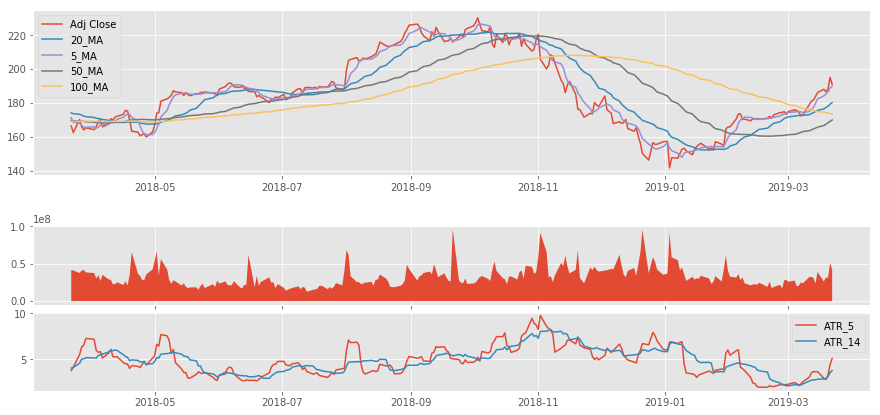

In [13]:
ax1 = plt.subplot2grid((9,1), loc=(0,0), rowspan=4, colspan=(1))
ax2 = plt.subplot2grid((9,1), loc=(5,0), rowspan=2, colspan=(1), sharex=ax1)
ax3 = plt.subplot2grid((9,1), loc=(7,0), rowspan=2, colspan=(1), sharex=ax1)
start = -252 #1 trading year
end = -1


ax1.plot(aapl_df.index[start:], aapl_df['Adj Close'][start:])
ax1.plot(aapl_df.index[start:], aapl_df['20_MA'][start:])
ax1.plot(aapl_df.index[start:], aapl_df['5_MA'][start:])
ax1.plot(aapl_df.index[start:], aapl_df['50_MA'][start:])
ax1.plot(aapl_df.index[start:], aapl_df['100_MA'][start:])
ax2.fill_between(aapl_df.index[start:], aapl_df['Volume'][start:], 0)
#ax2.ylabel('Volume')
ax3.plot(aapl_df.index[start:], aapl_df['ATR_5'][start:])
ax3.plot(aapl_df.index[start:], aapl_df['ATR_14'][start:])
ax1.legend()
ax3.legend()
plt.show()

# Analyzing trends and which metrics to pick

In the above graph, we have mapped out the adjusted closing price of Apple stock, 4 variations of of the rolling moving average (5 day, 20 day, 50 day, and 100 day), volume of stock being traded, and finally the average true range (ATR) with a window of 5 and 14 days.

From the top graph, we see that the 100 day moving average finds the larger trend over time, but lags behind quite a bit in the volative ups and downs of the stock price. The 50 day seems to be similar to the 100 day one, but lags behind a bit less. The 20 day MA gets close to the close price, but seems to be lagging behind the actual price trends as well. The 5 day MA gets the closest to the actual trend of the stock, but it's also the most volatile of the 4. 

Another thing we see is that volume seems to correlate with volatility of the stock. Although not perfect, increases in volume seem to mark changes in stock price, whether that's up or down.
Finally, we analyze the average true range. It also seems to have a slight trend associated with price of stock, although not as consistently as volume. The 5 day window seems to correlate the most with upticks in volume, while the 14 day windows goes towards the overall trend.

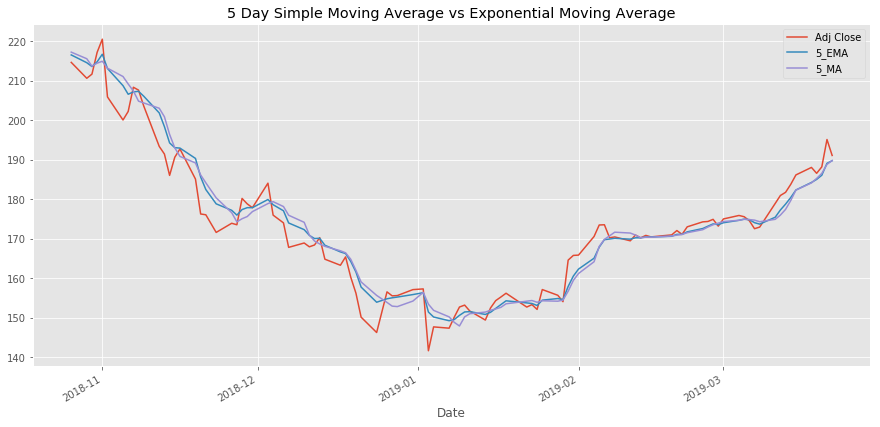

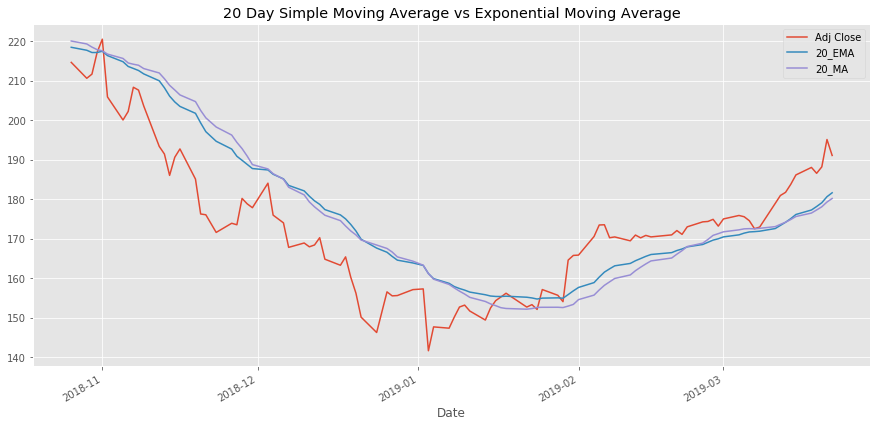

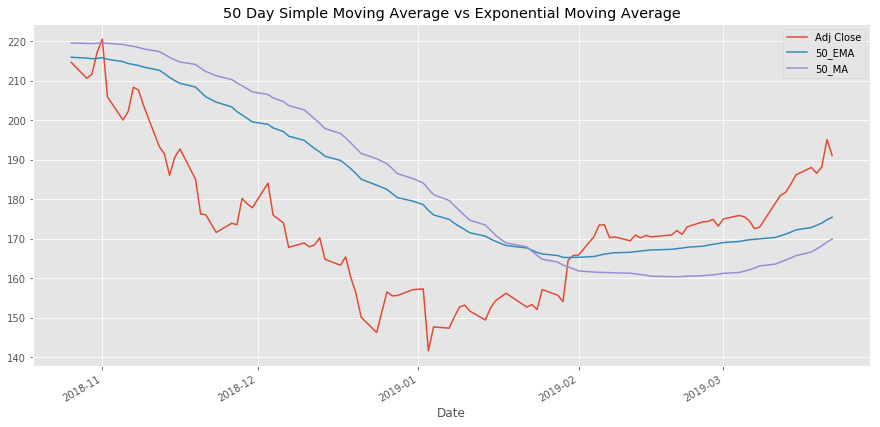

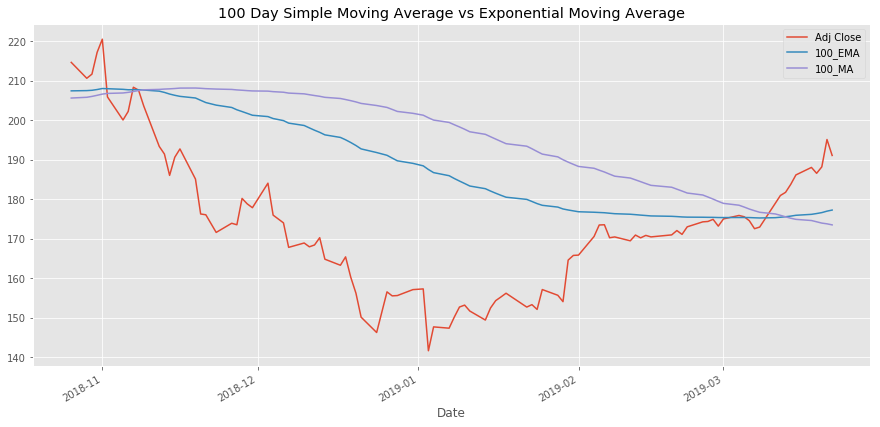

In [14]:
plot_obj = aapl_df[['Adj Close', '5_EMA', '5_MA']][-100:]
plot_obj.plot()
plt.title("5 Day Simple Moving Average vs Exponential Moving Average")
plt.show()

plot_obj = aapl_df[['Adj Close', '20_EMA', '20_MA']][-100:]
plot_obj.plot()
plt.title("20 Day Simple Moving Average vs Exponential Moving Average")
plt.show()

plot_obj = aapl_df[['Adj Close', '50_EMA', '50_MA']][-100:]
plot_obj.plot()
plt.title("50 Day Simple Moving Average vs Exponential Moving Average")
plt.show()

plot_obj = aapl_df[['Adj Close', '100_EMA', '100_MA']][-100:]
plot_obj.plot()
plt.title("100 Day Simple Moving Average vs Exponential Moving Average")
plt.show()

Comparing the EMA to SMA, we see that these measures are very similar. On smaller time scales, such as the 5 day one, we see that there is little to no difference between the two. But when we start increasing the scale, we start to see that the EMA becomes more response to recent price trends. Due to the nature of EMA's weighting recent days in their window more strongly, they are a better measure once the window becomes large  enough. For now, we see that the EMA has better potential for our purposes as a single trend line isn't too useful by itself. It's when we start combining low and high frequency (relative to this context) trend lines can we identify deeper patterns. The problem now with EMAs is that they dont take intra day price shifts into account. All they really look at are close-close price trends.

The Kaufman Adaptive Moving Average (KAMA) is a very complex trend indicator and is one of the more recent and popular ones to be developed in the list. It takes the concept of exponential moving averages and adds in the concept of volatility to further distinguish it as a trend indicator.

In [15]:
def KAMA(price, n=10, pow1=2, pow2=30):
    ''' kama indicator - As suggested by Perry Kaufman, we will use KAMA(10,2,30) as the constants
        * 10 is the number of periods for the Efficiency Ratio (ER).
        * 2 is the number of periods for the fastest EMA constant.
        * 30 is the number of periods for the slowest EMA constant.'''    
    ''' accepts pandas dataframe of prices '''
    """ We need the Efficiency Ratio (ER) and Smoothing Constant (SC) to get KAMA.
        ER = Change/Volatility
        
        Change = ABS(Close - Close (10 periods ago))
        Volatility = Sum10(ABS(Close - Prior Close))
        Volatility is the sum of the absolute value of the last ten price changes (Close - Prior Close).
        
        SC = [ER x (fastest SC - slowest SC) + slowest SC]2
        SC = [ER x (2/(2+1) - 2/(30+1)) + 2/(30+1)]2"""

    absDiffx = abs(price.diff()) 

    ER_change = abs( price - price.shift(n) )
    ER_volatility = absDiffx.rolling(10).sum()
    ER = ER_change / ER_volatility

    sc = ( ER*(2.0/(pow1+1)-2.0/(pow2+1.0))+2/(pow2+1.0) ) ** 2


    answer = np.zeros(sc.size)
    N = len(answer)
    first_value = True

    for i in range(N):
        if sc[i] != sc[i]:
            answer[i] = np.nan
        else:
            if first_value:
                answer[i] = price[i]
                first_value = False
            else:
                answer[i] = answer[i-1] + sc[i] * (price[i] - answer[i-1])
    return answer

short_power = 2
long_power = 5
aapl_df['KAMA_10_{}_30'.format(short_power)] = KAMA(aapl_df['Adj Close'])
aapl_df['KAMA_10_{}_30'.format(long_power)] = KAMA(aapl_df['Adj Close'], pow1=5)

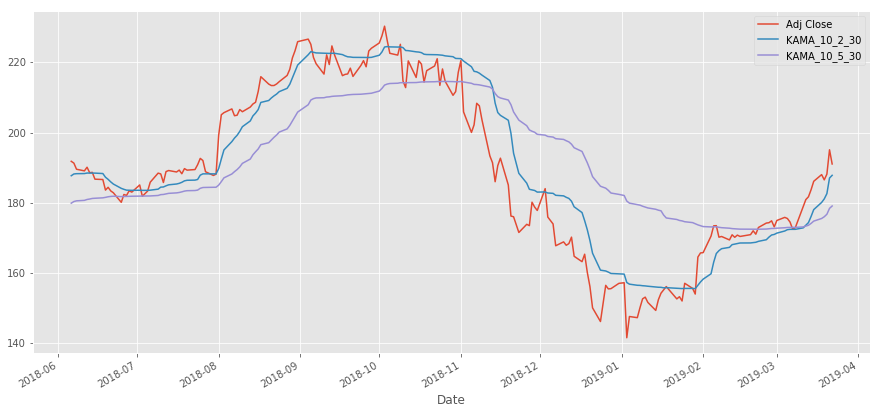

In [16]:
aapl_df[['Adj Close', 'KAMA_10_2_30', 'KAMA_10_5_30']].iloc[-200:].plot()
plt.show()

In [23]:
def kama_signals(df):
    short_shift = df['KAMA_10_2_30'].shift()
    long_shift = df['KAMA_10_5_30'].shift()
    df['KAMA_sell'] = np.where(((short_shift > long_shift) & (df['KAMA_10_2_30']<=df['KAMA_10_5_30'])), 1, 0)
    df['KAMA_buy'] = np.where(((short_shift < long_shift) & (df['KAMA_10_2_30']>=df['KAMA_10_5_30'])), 1, 0)
    
kama_signals(aapl_df)

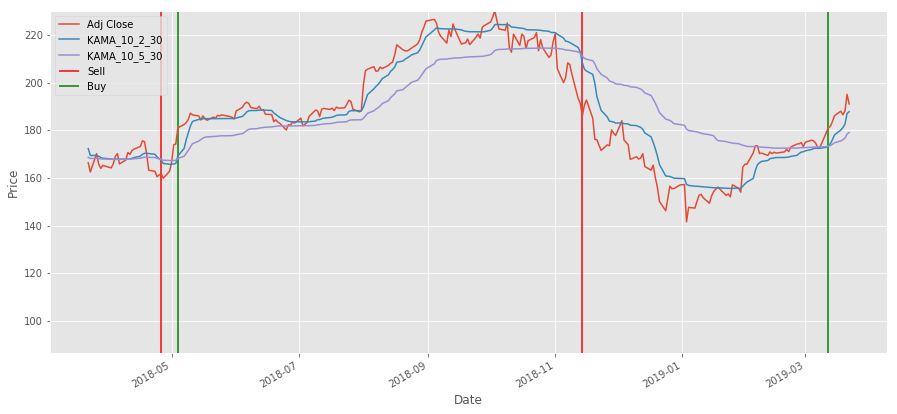

DatetimeIndex(['2015-07-08', '2015-11-16', '2015-12-03', '2015-12-09',
               '2016-04-27', '2016-06-17', '2016-11-10', '2018-02-02',
               '2018-04-26', '2018-11-14'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [24]:
start = -252
aapl_df.loc[:,['Adj Close', 'KAMA_10_2_30', 'KAMA_10_5_30']][start:].plot()

plt.vlines(aapl_df.iloc[start:].loc[aapl_df['KAMA_sell']==1].index, 
           ymin=aapl_df['Adj Close'].min(), 
           ymax=aapl_df['Adj Close'].max(), 
           label='Sell',
           colors='r')

plt.vlines(aapl_df.iloc[start:].loc[aapl_df['KAMA_buy']==1].index, 
           ymin=aapl_df['Adj Close'].min(), 
           ymax=aapl_df['Adj Close'].max(), 
           label='Buy',
           colors='g')

plt.ylabel("Price")
plt.legend()
plt.ylim(aapl_df['Adj Close'].min() ,aapl_df['Adj Close'].max())
plt.show()

Judging from the above graph, we see KAMA_10_2_30 cross KAMA_10_5_30 a few times around key points of the stock movement. For convenience sake, I shall refer to KAMA_10_2_30 as small_KAMA and KAMA_10_5_30 as large_KAMA. Whenever the small_KAMA cross above the the large_KAMA from below, this usually indicates a bullish moveement. When the small_KAMA cross below the large_KAMA, it usually indicates a bearish signal. Do note that these signals lag behind (come after) the actual time when the price trend starts to go down so we have to consider that into our strategy. Judging by the signals created, we missed quite a few points of entry and exit, even though our signals are around points where the short KAMA line crosses the long KAMA line. This tool is better used as a chart reading skill than a aolgorithmic signal. Whenever KAMA increases, then the stock price increases as well and is very responsive to recent stock prices. With this, we can see how increases in KAMA usually follow a period of stabilized KAMA then it goes down. Generally, this pattern continues on for a stock unless outside factors lead to drastic changes in the stock performance such as sentiment changes and changes to the law. 

## Overlays continued - Bollinger bands

Bollinger bands are one of the tools used in technical analysis to assess risk in stock price based on volatility and was developed and made famous by a famous technical trader, John Bollinger. 

Volatility can be seen as a measure of how far a stock may move away from the mean. A stock entering a period of high volatility means that the moving average of the price for the stock/security/bond etc will divert away from that mean value greatly and low volatility means that the price swing will be more tight. 

Bollinger bands can be plotted as a central trend line for a stock calculated through a moving average and then has an upper and lower limit which is usually 2 standard deviations away from the average price. This way we capture about 95% of the price swings and anything above or below that is a sure signal for a trend change. As mentioned earlier, high volatility is characterized by wider bands while lower volatility leads to the band contracting. Another general trend seen in stocks is periods of higher volatlity are usually followed by periods of low volatility and vice versa. Stocks don't follow a smooth normal trend but in fact operate in swings. However, this volatility spread is a double-edged sword. Higher volatility can be seen as a measure of risk in that the stock may either rise heavily or fall drastically. Hence the aspect of risk. This volatility measure does not tell us the direction of the swing, but rather shows us general trend guidelines that a stock may undergo. 

In [25]:
def set_bollinger_bands(df, window):
    std_size=2
    roll = df['Adj Close'].rolling(window)
    df['Bollinger_upper'] = roll.mean() + roll.std()*std_size
    df['Bollinger_lower'] = roll.mean() - roll.std()*std_size
    df['Bollinger_middle'] = roll.mean()

In [26]:
set_bollinger_bands(aapl_df, 20)

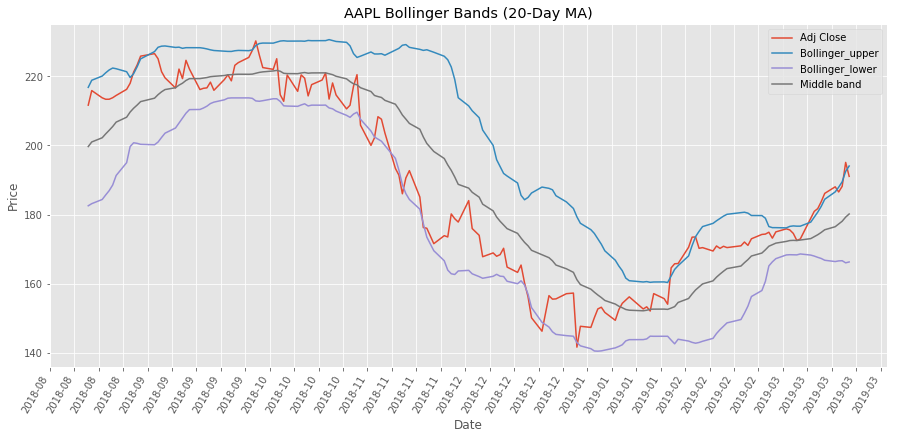

In [27]:
start=-150
fig, ax = plt.subplots()
aapl_df['Adj Close'][start:].plot(kind='line')
aapl_df['Bollinger_upper'][start:].plot(kind='line')
aapl_df['Bollinger_lower'][start:].plot(kind='line')
aapl_df['Bollinger_middle'][start:].plot(kind='line', label='Middle band')
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.xticks(rotation=60)
plt.title("AAPL Bollinger Bands (20-Day MA)")
plt.ylabel('Price')
plt.legend()
plt.show()

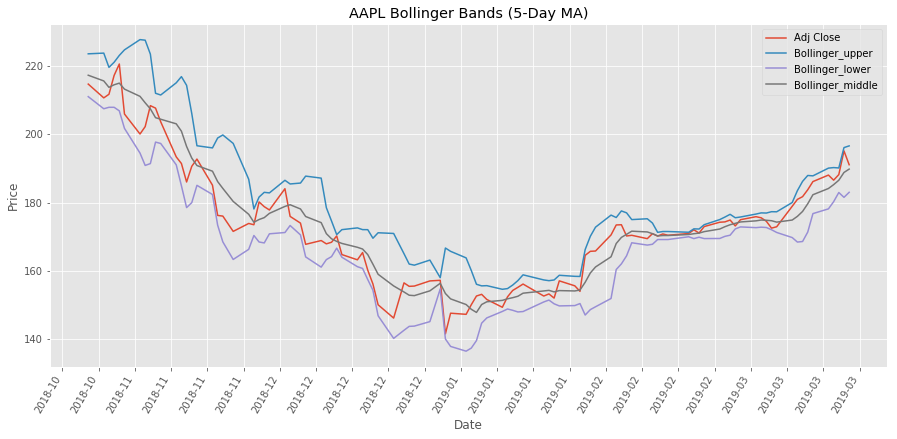

In [29]:
set_bollinger_bands(aapl_df, 5)

fig, ax = plt.subplots()
start=-100
aapl_df['Adj Close'][start:].plot(kind='line')
aapl_df['Bollinger_upper'][start:].plot(kind='line')
aapl_df['Bollinger_lower'][start:].plot(kind='line')
aapl_df['Bollinger_middle'][start:].plot(kind='line')
plt.xticks(rotation=60)
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.title("AAPL Bollinger Bands (5-Day MA)")
plt.ylabel('Price')
plt.legend()
plt.show()

From the bollinger bands, we see that have a slightly longer window leads to more variable windows of band contraction and expansion. This allows us to get a better picture of price trend movement as opposed to the smaller window of 5 trading days. So, the optimal seetings seem to be keeping a window of 20 days.

# Oscillators - technical signals that follow the up and down flow of stocks to find out if a stock is overbought or oversold

### Relative Strength Index (RSI)

RSI is used to measure the change and speed of price fluctuations. It provides an idea as to the recent performance of a stock in the amrket. The scale of this is from 0 to 100. Usually, if the RSI of a stock is above 70, then it's overbought and is likely due to drop in price. If the RSI is below 30, then a stock is oversold and will likely increase in price soon. RSI is calculated from the following $$ RSI = 100 - 100/ (1 + RS) $$

RS in this case is the average gain from a specified time period. 

In [32]:
def set_RSI(df, window=14):
    df['RSI'] = ta.RSI(df['Adj Close'].values, timeperiod=window)
    
    
def plot_RSI(df):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(df.index, df.RSI, label='RSI')
    ax.fill_between(df.index, y1=25, y2=80, color = 'lightcoral', alpha='0.3')
    ax.set_xlabel('Date')
    ax.set_ylabel('RSI')
    plt.show()

In [33]:
set_RSI(aapl_df)
aapl_df.tail()

,Open,High,Low,Close,Adj Close,Volume,Date,High-Low,|H-Cp|,|L-Cp|,...,100_EMA,Log_Returns,KAMA_10_2_30,KAMA_10_5_30,KAMA_sell,KAMA_buy,Bollinger_upper,Bollinger_lower,Bollinger_middle,RSI
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-18,185.800003,188.389999,185.789993,188.020004,188.020004,26219800,737136.0,2.600006,2.270004,0.330002,...,176.134060,0.010157,180.102496,175.534313,0,0,190.053825,178.142178,184.098001,77.677263
2019-03-19,188.350006,188.990005,185.919998,186.529999,186.529999,31646400,737137.0,3.070007,0.970001,2.100006,...,176.339920,-0.007956,181.105539,176.028832,0,0,190.212617,180.231384,185.222000,72.947896
2019-03-20,186.229996,189.490005,184.729996,188.160004,188.160004,31035200,737138.0,4.760009,2.960006,1.800003,...,176.573981,0.008701,182.611685,176.739238,0,0,190.101363,182.922636,186.512000,74.758448
2019-03-21,190.020004,196.330002,189.809998,195.089996,195.089996,51034200,737139.0,6.520004,8.169998,1.649994,...,176.940635,0.036168,187.051474,178.412951,0,0,196.058344,181.509655,188.784000,80.679061
2019-03-22,195.339996,197.690002,190.779999,191.050003,191.050003,42359300,737140.0,6.910003,2.600006,4.309997,...,177.220029,-0.020926,187.820642,179.090282,0,0,196.559180,182.980823,189.770001,70.323292


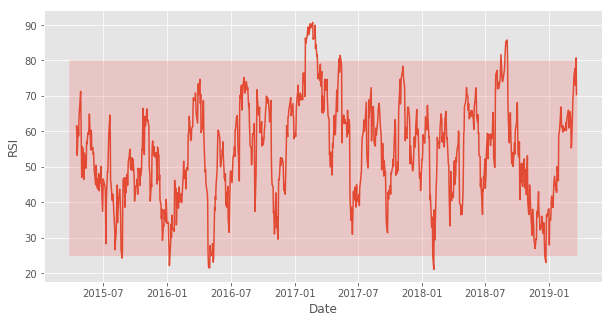

In [34]:
plot_RSI(aapl_df)

# Volume - Indicators tracking volume at an absoulte or relative level

This is a straightforward technical indicator but a very important one. Volume and price are very closely related in that it indicates momentum about a stocks price. Some common indicators for this is the regular volume and on-balance volume.

On balance volume is the flow of volume in relation to total volume. Increases in OBV usually mean icnreases in stock price and vice versa. The actual value of OBV does not matter as it's a relative value in accordance to the start period we give it. What matters is the slope of the line as OBV changes over time. OBV is calculated as follows: <img src="https://www.investopedia.com/thmb/qyg3KOLEiR_soihtw8zxexYkZqg=/1280x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/latex_857b49bb29298504668777b5476605c5-5c4f426d46e0fb000167c88a.jpg" style="width: 500px;">


This value shows the realtionship of volume change in relation to price. Usually, large investment firms will buy large amounts of volume, even if price stays relatively the same. Eventually, the price will inevitably rise due to volume increases thus leading them to sell the stock and causing retail consumers/investors to buy the stock. The main idea for investment firms is to increase volume so that other small investors join in and sell at an opportune moment to reap the profits.

In [39]:
def set_OBV(df):
    df['OBV'] = ta.OBV(df['Adj Close'].values, df['Volume'].astype(np.float64).values)
    
set_OBV(aapl_df)

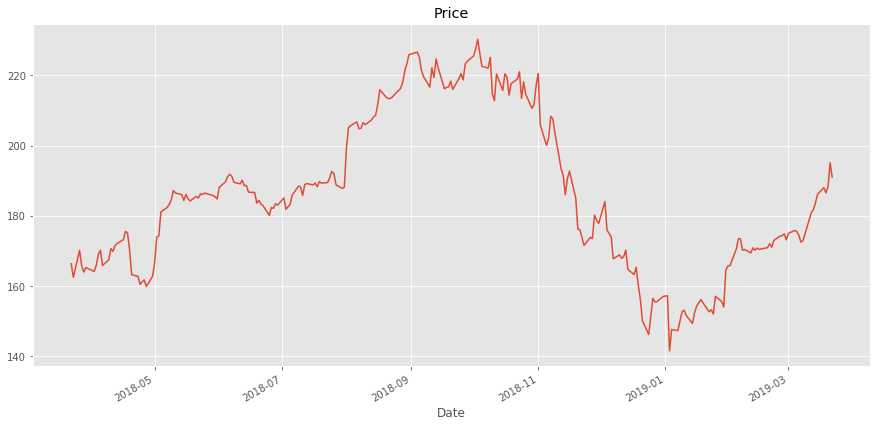

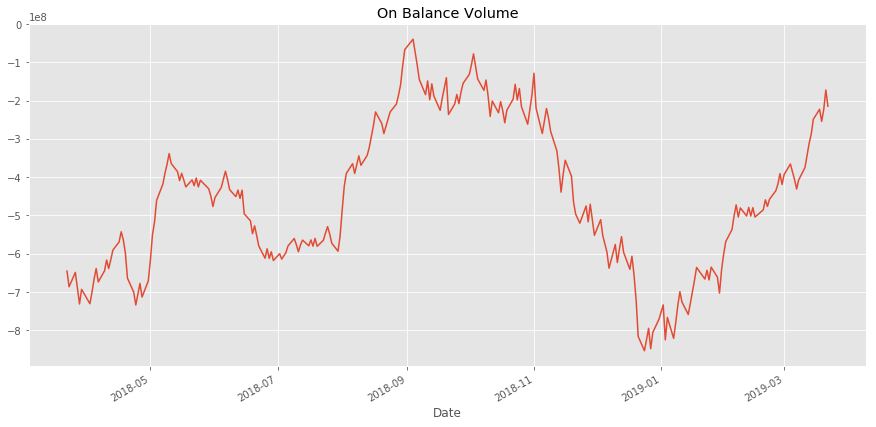

In [40]:
aapl_df['Adj Close'][-252:].plot()
plt.title("Price")
plt.show()

aapl_df['OBV'][-252:].plot()
plt.title("On Balance Volume")
plt.show()

As you can see, OBV and price are very closely related and may serve as a helpful technical indicator. 

# Setting Up Entry and Exit signals

Generally, we want to have two different strategies in order to decide when to enter a trade and when to exit. 



Given this tool, if we plot the bollinger bands for recent stocks and see that the bands are somewhat constricted compared to the past, we can expect a period of higher volatility approaching and can use this to set up entry and exit points for our strategy. One example could be to buy a stock and wait for it to go above 10% in profits then sell. The exit strategy could be to sell if the stock goes below 20% of the invested amount to stop any further losses and reassess from there. The problem with this strategy is that one can miss out on larger trend changes if the stock is in an uptrend and certain pullbacks can cause one to short a stock even though a larger upwards trend might be indicated by other signals.

One common exit strategy is based on how a stocks current close price deviates from yesterdays close price. By using ATR, we can set up signals to sell our stock when it starts to trend downwards based on volatility

In [41]:
def ATR_exits(df):
    df['ATR_exit'] = np.where(df['Adj Close'] < df['Adj Close'].shift()-df['ATR_14']*1.5, 1, 0)
ATR_exits(aapl_df)

In [42]:
aapl_df[aapl_df['ATR_exit']==1]

,Open,High,Low,Close,Adj Close,Volume,Date,High-Low,|H-Cp|,|L-Cp|,...,KAMA_10_2_30,KAMA_10_5_30,KAMA_sell,KAMA_buy,Bollinger_upper,Bollinger_lower,Bollinger_middle,RSI,OBV,ATR_exit
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-02,166.000000,166.800003,160.100006,160.500000,157.450745,86593800,736727.0,6.699997,2.207565,4.492432,...,163.732224,166.017150,1,0,169.188919,156.754727,162.971823,24.843982,-547490200.0,1
2018-10-10,225.460007,226.350006,216.050003,216.360001,214.686966,41990600,736977.0,10.300003,1.234329,9.065674,...,224.177166,214.188718,0,0,231.140976,213.109012,222.124994,42.696831,-188400800.0,1
2018-11-02,209.550003,213.649994,205.429993,207.479996,205.875610,91328700,737000.0,8.220001,6.851639,15.071640,...,220.355067,214.391326,0,0,224.641925,201.675800,213.158862,40.283096,-219872600.0,1
2019-01-03,143.979996,145.720001,142.000000,142.190002,141.582779,91312200,737062.0,3.720001,11.525604,15.245605,...,157.307067,180.493395,0,0,166.688309,140.087984,153.388147,27.903517,-825043900.0,1


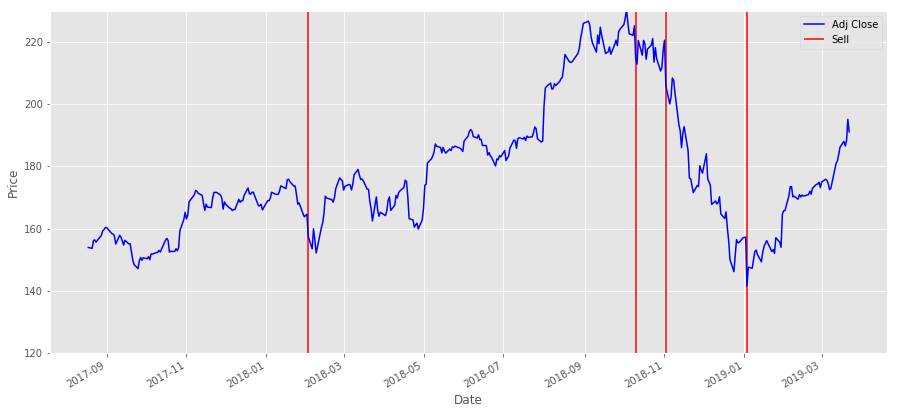

In [45]:
start = -400
aapl_df.loc[:,'Adj Close'].iloc[start:].plot(color='b')

plt.vlines(aapl_df.loc[aapl_df['ATR_exit']==1].iloc[start:].index, 
           ymin=aapl_df['Adj Close'].min(), 
           ymax=aapl_df['Adj Close'].max(), 
           label='Sell',
           colors='r')
plt.ylabel("Price")
plt.legend()
plt.ylim(120, 230)
plt.show()

Although there are certain points the signal gets right, the ATR exit signal is too vulneratble to sharp dips and can lead to incorrect sell signals. Further exit strategy's should be tested.

In [46]:
def rsi_signals(df):
    df['RSI_entry'] = np.where(df['RSI']<25, 1, 0)
    df['RSI_exit'] = np.where(df['RSI']>80, 1, 0)
    
rsi_signals(aapl_df)

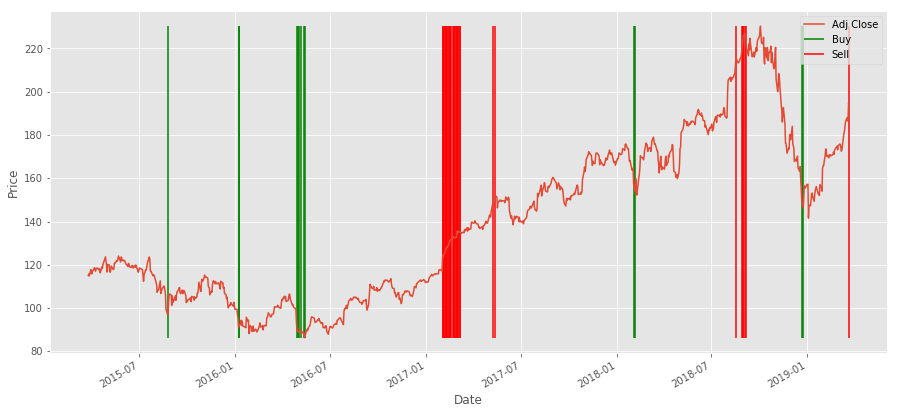

In [48]:
start = 0
aapl_df.loc[:,'Adj Close'].iloc[start:].plot()

plt.vlines(aapl_df.loc[aapl_df['RSI_entry']==1].iloc[start:].index, 
           ymin=aapl_df['Adj Close'].min(), 
           ymax=aapl_df['Adj Close'].max(), 
           label='Buy',
           colors='g')

plt.vlines(aapl_df.loc[aapl_df['RSI_exit']==1].iloc[start:].index, 
           ymin=aapl_df['Adj Close'].min(), 
           ymax=aapl_df['Adj Close'].max(), 
           label='Sell',
           colors='r')
plt.ylabel("Price")
#plt.ylim(120,230)
plt.legend()
plt.show()

RSI seems to be a very good indicator for buying and selling without overpopulating with signals that might be noise as seen from the other signals before. But when we see earlier on in Apple's timeline, we see that the RSI didn't account for some points of stability as buy signals and the stocks RSI showed sell signals quite more often than buy signals. Maybe if RSI is just used for buy signals then it has good potential. 

# Checking for stationary in data before  we start modeling

Other than visual inspection of our data as well as looking at descriptive statistics for our stocks to determine stationarity, we can rely on more stringent statistical tests to evaluate the degree to which our data is likely to be stationary or not.

Based on previous inspection of the TSLA stock, we can clearly see that there is a trend to the data. Seasonality does not seem be as apparent at the monthly or weekly level.

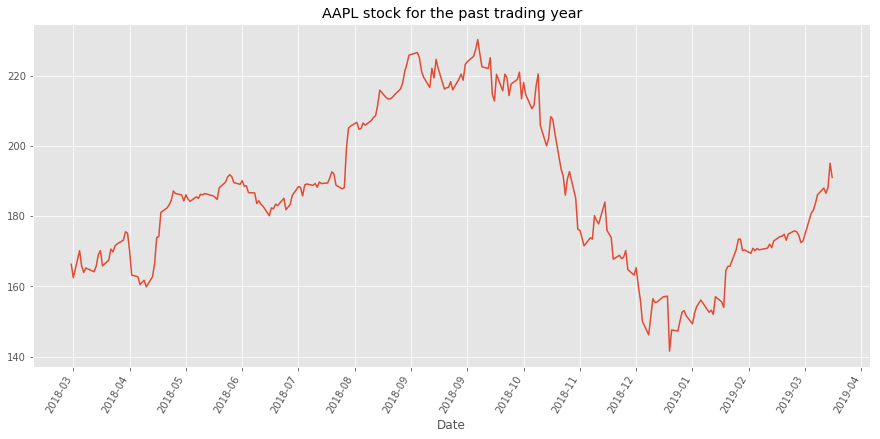

In [49]:
fig, ax = plt.subplots()
aapl_df['Adj Close'][-252:].plot()
plt.title("AAPL stock for the past trading year")
ax.xaxis.set_major_locator(ticker.MultipleLocator(27))
plt.xticks(rotation=60)
plt.show()

Visual inspection shows us that the regular stock close price is not stationary nor does it seem to have any trends in the recent months. There doen't seem to be any seasonality but there does seem to be a trend.

In [50]:
# Running statistical tests to check for stationarity
def check_stationarity(df, item):
    X = df[str(item)]
    result = adfuller(X)
    print('ADF Statistic: {:.3f}'.format(result[0]))
    print('p-value: {:.3f}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.3f}'.format(key, value))
    return
        
check_stationarity(aapl_df.loc['2012':'2017-12-31'], 'Adj Close')

ADF Statistic: 0.117
p-value: 0.967
Critical Values:
	5%: -2.866
	10%: -2.569
	1%: -3.440


The above result shows that our Apple stock close price is likely to not be stationary as the p value for our result was above .05, therefor we cannot reject the null hypothesis that our data is not stationary.

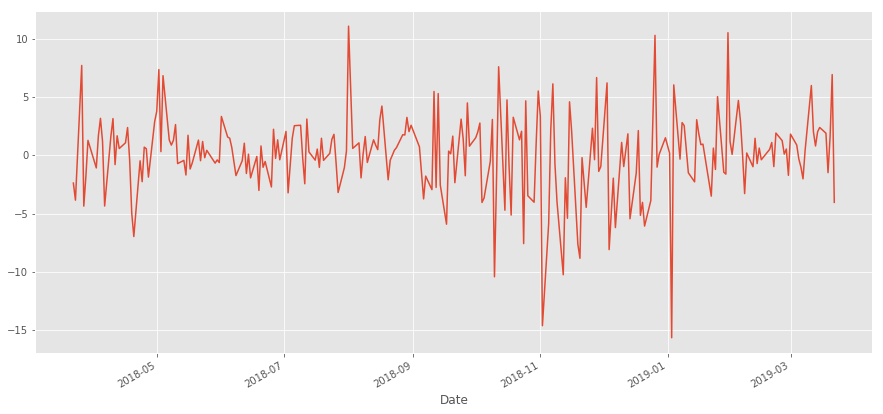

In [51]:
aapl_df['Diff_1'] = aapl_df['Adj Close'] - aapl_df['Adj Close'].shift(1)
aapl_df['Diff_1'][-252:].plot()
plt.show()

In [52]:
check_stationarity(aapl_df[-252:], 'Diff_1')

# It seems like our differences data is stationary after all

ADF Statistic: -15.944
p-value: 0.000
Critical Values:
	5%: -2.873
	10%: -2.573
	1%: -3.457


# Using log of the closing price to make data stationary

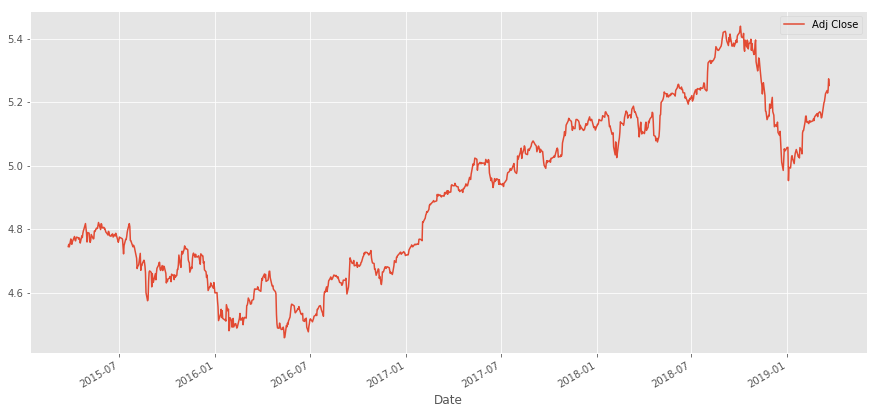

In [53]:
aapl_log_price = pd.DataFrame(np.log(aapl_df['Adj Close']), index=aapl_df.index)
aapl_log_price.plot()

In [54]:
aapl_log_price['diff'] = aapl_log_price - aapl_log_price.shift()

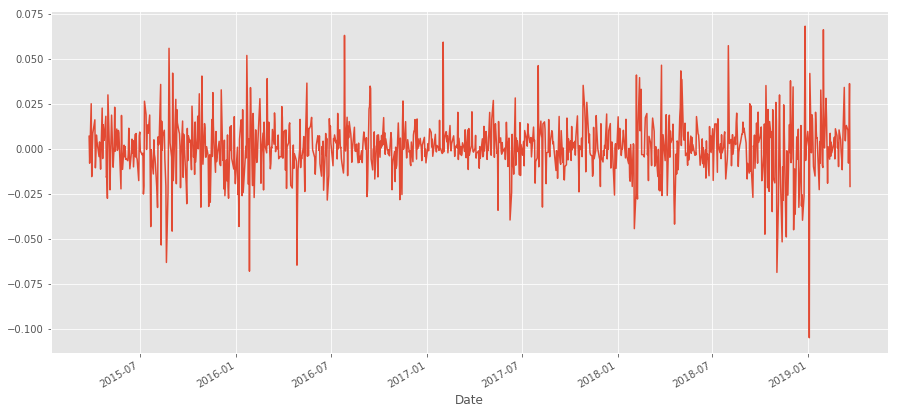

In [55]:
aapl_log_price['diff'].plot()

### Looking at the data, the differenced portion is mostly stationary except for one portion in 2001, so we can exclude that by taking data from a window

In [56]:
check_stationarity(aapl_log_price.dropna(), 'diff')

ADF Statistic: -31.269
p-value: 0.000
Critical Values:
	5%: -2.864
	10%: -2.568
	1%: -3.437


The Dukey-Fuller test confirms the assumptions from the graph that the data does seem to be stationary since the statistic value is small and the p value is significant. 

# Modeling price
The ARCH or Autoregressive Conditional Heteroskedasticity method provides a way to model a change in variance in a time series that is time dependent, such as increasing or decreasing volatility. But before we get into the details for such modeling, we have to understand why we are using this method in the first place.

Autoregressive models have been developed to capture time series data that is stationary (AR), has a trend (ARIMA), and has a seasonal component as well (SARIMA). These models try to model the conditional mean of a stochastic process. The problem with these models is that they do not capture variance over a period of time. In some cases with modest variance in the time series data we could apply a log or box cox transformation to the stationary data in order to capture that effect, but that won't always be the case. Most of the time in real world data, we have different variances for the time series at various points in time. This refers to the heteorskedastic nature of the data. This is where ARCH models were developed to capture and model this uneven variance over time.

ARCH models try to model the variance in a time series at every time step as a function by looking at the residual errors from a mean process (such as 0 mean). ARCH models take a parameter called __q__ that is the lag order for the residual term. It refers to how far back in error terms it should look for modeling variance. Like ARMA models and its variants, the data is expected to be stationary. 

ARCH models should be used on top of ARMA models to capture both the conditional mean and variance of a stochastic process. 

In [104]:
train = aapl_df.iloc[:-100].loc[:,'Adj Close'].rolling(window=5).mean()
train_log = train.map(np.log)
test = aapl_df.iloc[-100:].loc[:, 'Adj Close'].rolling(window=5).mean()
test_log = test.map(np.log)

print("Train samples:", len(train))
print("Test samples:", len(test))

Train samples: 906
Test samples: 100


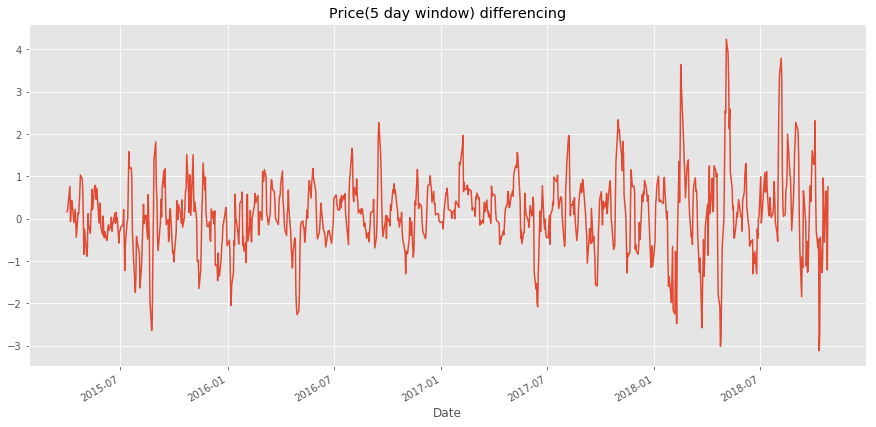

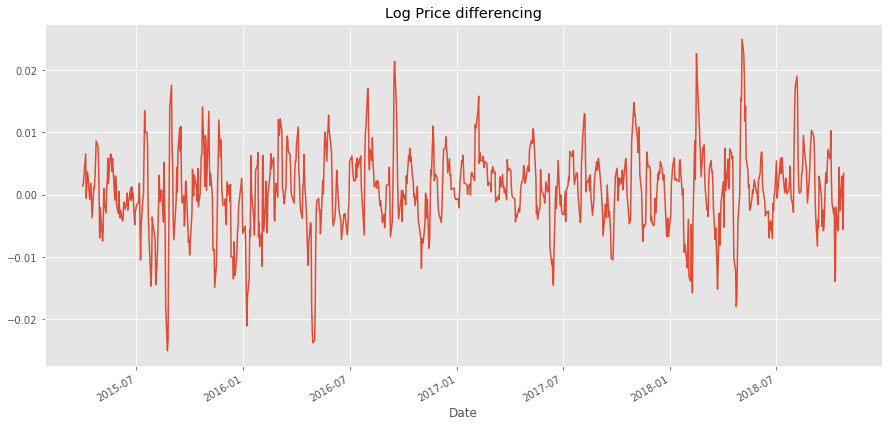

In [121]:
diff = train - train.shift()
diff.plot()
plt.title('Price(5 day window) differencing')
plt.show()

diff = train_log - train_log.shift()
diff.plot()
plt.title('Log Price differencing')
plt.show()

In [118]:
arima = auto_arima(train.dropna(), 
                   start_p=2, 
                   max_p=4, 
                   start_q=2, 
                   max_q=4, 
                   seasonal=False, # stock data did not seem to be seasonal from bisual inspection
                   m=12,
                   D=1,
                   information_criterion='bic'
                  )
model_fit = arima.fit(train.dropna())

print(model_fit.summary())

C:\Users\sohai\Miniconda3\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\sohai\Miniconda3\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sohai\Miniconda3\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sohai\Miniconda3\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sohai\Miniconda3\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimizati

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  900
Model:                 ARIMA(4, 2, 3)   Log Likelihood                -560.751
Method:                       css-mle   S.D. of innovations              0.448
Date:                Sun, 24 Mar 2019   AIC                           1139.501
Time:                        21:37:44   BIC                           1182.723
Sample:                             2   HQIC                          1156.012
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      2.027      0.043    1.51e-05       0.001
ar.L1.D2.y     1.4116      0.032     44.010      0.000       1.349       1.474
ar.L2.D2.y    -1.2684      0.051    -25.013      0.0

C:\Users\sohai\Miniconda3\envs\tfgpu\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\sohai\Miniconda3\envs\tfgpu\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\sohai\Miniconda3\envs\tfgpu\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [119]:
pred = model_fit.predict(n_periods=len(test))
predictions = pd.Series(pred, index=test.index)

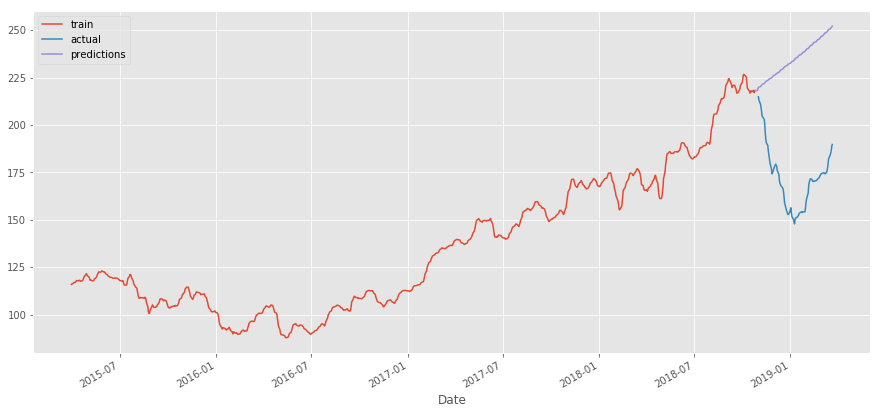

In [120]:
train.plot(label='train')
test.plot(label='actual')
predictions.plot(label='predictions')
plt.legend()
plt.show()

In [115]:
arima = auto_arima(train_log.dropna(), 
                   start_p=2, 
                   max_p=4, 
                   start_q=2, 
                   max_q=4, 
                   seasonal=False, # stock data did not seem to be seasonal from bisual inspection
                   m=12,
                   D=1,
                   information_criterion='bic'
                  )
model_fit = arima.fit(test_log.dropna())

print(model_fit.summary())

C:\Users\sohai\Miniconda3\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   95
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 344.504
Method:                       css-mle   S.D. of innovations              0.006
Date:                Sun, 24 Mar 2019   AIC                           -679.009
Time:                        21:35:46   BIC                           -666.239
Sample:                             1   HQIC                          -673.849
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.002     -0.591      0.556      -0.006       0.003
ar.L1.D.y      1.7550      0.065     26.992      0.000       1.628       1.882
ar.L2.D.y     -0.7570      0.065    -11.689      0.0

In [116]:
pred = model_fit.predict(n_periods=len(test_log))
predictions = pd.Series(pred, index=test.index)
predictions = predictions.map(np.exp)

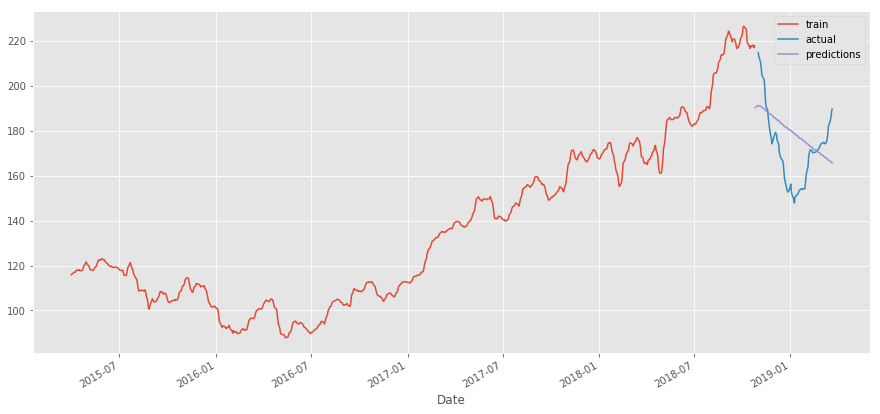

In [117]:
train.plot(label='train')
test.plot(label='actual')
predictions.plot(label='predictions')
plt.legend()
plt.show()

Judging by the ARIMA model, we see that it has captured the downward trend based on previous data, but it still hasn't fully captured the seaspnal component of the data.

In [130]:
train.head()

Date
2015-03-25    115.027771
2015-03-26    115.829559
2015-03-27    114.906578
2015-03-30    117.815361
2015-03-31    116.006676
Name: Adj Close, dtype: float64

In [131]:
train = aapl_df.iloc[:-100].loc[:, 'Adj Close']
test = aapl_df.iloc[-100:].loc[:, 'Adj Close']

In [135]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(len(train),1,1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train, test, epochs=10, batch_size=1, verbose=2)


ValueError: Input 0 is incompatible with layer lstm_11: expected ndim=3, found ndim=4